In [26]:
import numpy as np
import scipy.stats as stats
from scipy.sparse import diags
import pandas as pd
from scipy.optimize import brentq
import matplotlib.pyplot as plt

In [27]:
def sigma(t,s):
    return (1+t/30)*(0.1+0.4*np.exp(-s/50))

In [75]:
r=0.01
T=1
s_min=10
s_max=300

#grid parameters
N=4000
M=580
dt=T/N
ds=(s_max-s_min)/M
s = np.linspace(s_min, s_max, M+1)

In [29]:
dt/(ds**2)

0.001

## Explicit Finite Difference Scheme

In [76]:
t = np.linspace(0, T, N+1)
t=t[:,np.newaxis]
sigma_matrix=sigma(T-t,s) #sigma(t0,s),sigma(t1,s),...,sigma(tn,s)
#due to change of variable for initial value problem use T-tin sigma function
#should have V with t changing along each row ie V(t0,s0) is above V(t1,s0)
a=sigma_matrix**2*(s**2)/2
b=r*s
c=r

A=dt/(ds**2)*a-dt/(2*ds)*b
B=-2*dt/(ds**2)*a-dt*c
C=dt/ds**2*a+dt/(2*ds)*b

In [32]:
#set up matrix for forward iterative scheme
# since our parameters are time dependent now the (I+L^n) is dependent on n
def tridiagonal_L(n):
    #calculate (L^n)
    A_diag=np.concatenate([A[n][1:M],[0]])
    B_diag=np.concatenate([[0],B[n][1:M],[0]])
    C_diag=np.concatenate([[0],C[n][1:M]])
    L_diags=diags([A_diag,B_diag,C_diag],[-1,0,1]).toarray()
    
    return(L_diags)


In [33]:
np.diag(tridiagonal_L(60),-1)

array([0.01055701, 0.0114117 , 0.01228502, 0.01317562, 0.0140822 ,
       0.01500351, 0.01593836, 0.0168856 , 0.01784414, 0.01881292,
       0.01979093, 0.02077722, 0.02177085, 0.02277096, 0.02377668,
       0.02478722, 0.02580181, 0.02681971, 0.02784022, 0.02886267,
       0.02988643, 0.03091089, 0.03193547, 0.03295962, 0.03398282,
       0.03500457, 0.03602441, 0.03704189, 0.03805658, 0.03906808,
       0.04007603, 0.04108005, 0.04207982, 0.04307502, 0.04406534,
       0.04505051, 0.04603027, 0.04700436, 0.04797257, 0.04893467,
       0.04989046, 0.05083976, 0.0517824 , 0.05271822, 0.05364708,
       0.05456883, 0.05548336, 0.05639055, 0.05729032, 0.05818256,
       0.05906719, 0.05994416, 0.06081339, 0.06167483, 0.06252844,
       0.06337419, 0.06421203, 0.06504196, 0.06586396, 0.06667801,
       0.06748413, 0.0682823 , 0.06907255, 0.06985488, 0.07062932,
       0.0713959 , 0.07215464, 0.07290558, 0.07364876, 0.07438422,
       0.075112  , 0.07583217, 0.07654477, 0.07724986, 0.07794

In [34]:
tridiagonal_L(60)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01055701, -0.02116902,  0.01060951, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.0114117 , -0.0228809 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.97307404,
         0.48728327,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.48731831,
        -0.97613663,  0.48881581],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Implementing a European Call

Think the boundary condition for our scheme should be $V(t,s_{max})=s_{max}-K(e^{-r(T-t)})$ since we are iterating backwards in time simply use $e^{-r\tau}$ 

In [35]:
K=100
#initial condition
v_ex=np.maximum(s-K,0)

I= np.identity(M+1)
#implement iterative scheme
for n in range(0,N):
    # v_x^n+1=(1+L^n)*v_x^n
    v_ex=np.matmul(I+tridiagonal_L(n),v_ex)
    
    #apply boundary condition
    v_ex[M]=s_max-np.exp(-r*dt*(n+1))*K
    v_ex[0]=0

In [36]:
v_ex

array([0.00000000e+00, 7.58096449e-16, 2.11232609e-15, 4.98059369e-15,
       1.10961888e-14, 2.38080038e-14, 4.94665752e-14, 9.98160587e-14,
       1.96044223e-13, 3.75497861e-13, 7.02596571e-13, 1.28623953e-12,
       2.30708598e-12, 4.05961690e-12, 7.01600267e-12, 1.19217028e-11,
       1.99366529e-11, 3.28411562e-11, 5.33325785e-11, 8.54481073e-11,
       1.35160766e-10, 2.11211261e-10, 3.26257924e-10, 4.98452009e-10,
       7.53577111e-10, 1.12793085e-09, 1.67217595e-09, 2.45644834e-09,
       3.57708389e-09, 5.16541606e-09, 7.39920616e-09, 1.05174000e-08,
       1.48390633e-08, 2.07875369e-08, 2.89210770e-08, 3.99715097e-08,
       5.48927409e-08, 7.49213240e-08, 1.01651713e-07, 1.37129315e-07,
       1.83965024e-07, 2.45475565e-07, 3.25854717e-07, 4.30381327e-07,
       5.65670994e-07, 7.39979356e-07, 9.63566164e-07, 1.24913065e-06,
       1.61233022e-06, 2.07239625e-06, 2.65286247e-06, 3.38242365e-06,
       4.29594441e-06, 5.43564059e-06, 6.85245806e-06, 8.60767695e-06,
      

## Implicit Finite Difference Scheme

In [37]:
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [38]:
v_im=np.maximum(s-K,0)

for n in range(1,N+1):

    L_diag=tridiagonal_L(n)
    a_diag=np.diag(L_diag,-1)
    b_diag=np.diag(L_diag)
    c_diag=np.diag(L_diag,1)
    d=v_im

    d[M]=s_max-np.exp(-r*dt*(n))*K
    v_im=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)

In [39]:
v_im

array([0.00000000e+00, 9.65096381e-16, 2.66719571e-15, 6.22715369e-15,
       1.37354629e-14, 2.91893852e-14, 6.00991326e-14, 1.20235471e-13,
       2.34245213e-13, 4.45248581e-13, 8.27102379e-13, 1.50383435e-12,
       2.67991916e-12, 4.68669595e-12, 8.05247691e-12, 1.36069650e-11,
       2.26347376e-11, 3.70980765e-11, 5.99567216e-11, 9.56216788e-11,
       1.50592603e-10, 2.34344214e-10, 3.60547551e-10, 5.48737599e-10,
       8.26571235e-10, 1.23285981e-09, 1.82161080e-09, 2.66737476e-09,
       3.87226917e-09, 5.57514320e-09, 7.96345817e-09, 1.12885930e-08,
       1.58854441e-08, 2.21973797e-08, 3.08078362e-08, 4.24801095e-08,
       5.82072072e-08, 7.92739953e-08, 1.07334295e-07, 1.44506079e-07,
       1.93488485e-07, 2.57705004e-07, 3.41477964e-07, 4.50240255e-07,
       5.90791200e-07, 7.71604573e-07, 1.00319796e-06, 1.29857404e-06,
       1.67374579e-06, 2.14835951e-06, 2.74643110e-06, 3.49721338e-06,
       4.43621429e-06, 5.60638830e-06, 7.05952607e-06, 8.85787024e-06,
      

## Crank Nicholson

In [40]:
v_cn=np.maximum(s-K,0)
theta=1/2

I= np.identity(M+1)

for n in range(1,N+1):
    L_diag_lhs=tridiagonal_L(n)
    L_diag_rhs=tridiagonal_L(n-1)
    
    d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
    #apply boundary condition
    d[M]=s_max-np.exp(-r*dt*(n))*K
    a_diag=np.diag(L_diag_lhs,-1)*theta
    b_diag=np.diag(L_diag_lhs)*theta
    c_diag=np.diag(L_diag_lhs,1)*theta
    v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)

In [41]:
v_cn

array([0.00000000e+00, 8.56473325e-16, 2.37652763e-15, 5.57551862e-15,
       1.23587643e-14, 2.63881860e-14, 5.45754230e-14, 1.09647138e-13,
       2.14471136e-13, 4.09203123e-13, 7.62861474e-13, 1.39172860e-12,
       2.48810280e-12, 4.36450210e-12, 7.52060475e-12, 1.27431953e-11,
       2.12534189e-11, 3.49210379e-11, 5.65725254e-11, 9.04291849e-11,
       1.42723647e-10, 2.22558754e-10, 3.43092862e-10, 5.23160949e-10,
       7.89472873e-10, 1.17957002e-09, 1.74577111e-09, 2.56039905e-09,
       3.72265552e-09, 5.36760136e-09, 7.67781095e-09, 1.08984024e-08,
       1.53563038e-08, 2.14848074e-08, 2.98546862e-08, 4.12134155e-08,
       5.65343531e-08, 7.70780951e-08, 1.04468649e-07, 1.40787559e-07,
       1.88689673e-07, 2.51544917e-07, 3.33611139e-07, 4.40243982e-07,
       5.78150660e-07, 7.55695614e-07, 9.83267228e-07, 1.27371614e-06,
       1.64287725e-06, 2.11018903e-06, 2.69942595e-06, 3.43956147e-06,
       4.36578149e-06, 5.52067083e-06, 6.95559741e-06, 8.73232228e-06,
      

In [42]:
s[140:230:10]

array([ 80.,  85.,  90.,  95., 100., 105., 110., 115., 120.])

In [43]:
call_prices=pd.DataFrame([v_ex[140:230:10],v_im[140:230:10],v_cn[140:230:10]],
                        index=['Explicit','Implicit','Crank-Nicholson'],
                        columns=s[140:230:10]).transpose()

In [44]:
call_prices

,Explicit,Implicit,Crank-Nicholson
80.0,0.751150,0.751276,0.751213
85.0,1.475574,1.475556,1.475565
90.0,2.646499,2.646289,2.646394
95.0,4.375359,4.374983,4.375171
100.0,6.729409,6.728962,6.729186
105.0,9.714493,9.714095,9.714294
110.0,13.275724,13.275464,13.275594
115.0,17.314719,17.314622,17.314670
120.0,21.714963,21.714998,21.714981


# Implied Volatility

In [45]:
def BlackScholesCall(sigma,s0,t,r,k):
    d1=(np.log(s0/k)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
    d2=(np.log(s0/k)+(r-sigma**2/2)*t)/(sigma*np.sqrt(t))
    return s0*stats.norm.cdf(d1)-k*np.exp(-r*t)*stats.norm.cdf(d2)


In [46]:
def ImpliedVol(s0,r,t,k,C):
    
    f = lambda sigma: BlackScholesCall(sigma,s0,t,r,k)-C
    implied_vol=brentq(f,0.0001,1)
    return implied_vol

In [47]:
def CrankNicholson(K):
    v_cn=np.maximum(s-K,0)
    theta=1/2

    I= np.identity(M+1)

    for n in range(1,N+1):
        L_diag_lhs=tridiagonal_L(n)
        L_diag_rhs=tridiagonal_L(n-1)

        d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
        #apply boundary condition
        d[M]=s_max-np.exp(-r*dt*(n))*K
        a_diag=np.diag(L_diag_lhs,-1)*theta
        b_diag=np.diag(L_diag_lhs)*theta
        c_diag=np.diag(L_diag_lhs,1)*theta
        v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)
        
    return v_cn

In [48]:
v_cn[180]

6.729185760335071

In [49]:
strike_range=np.arange(70,140,10)
m=len(strike_range)
s0=100
T=1
r=0.01
s0_index=np.where(s==s0)[0][0]

IVByStrike=np.zeros(m) #implied volatility for each strike

for i,k in enumerate(strike_range):
    Call_price=CrankNicholson(k)[s0_index] #index corresponding to an initial price of 100
    IVByStrike[i]=ImpliedVol(s0,r,T,k,Call_price)

Text(0, 0.5, 'Implied Volatility')

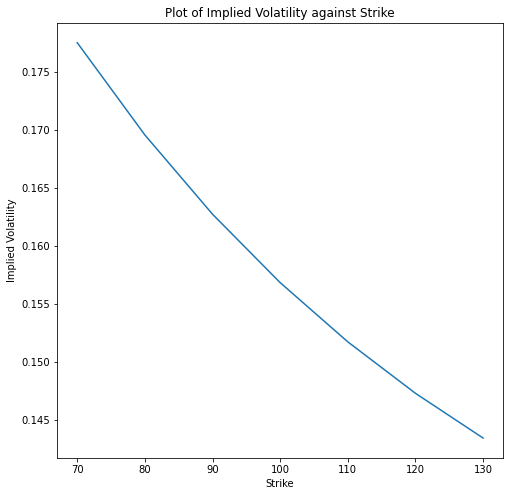

In [50]:
plt.figure(figsize=(8,8))
plt.plot(strike_range,IVByStrike)
plt.title("Plot of Implied Volatility against Strike")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")

In [54]:
pd.DataFrame(IVByStrike,index=strike_range,columns=["Implied Volatility"])

,Implied Volatility
70,0.177546
80,0.169578
90,0.162735
100,0.156829
110,0.151714
120,0.147272
130,0.143408


In [55]:
sigma_matrix_const=np.ones(sigma_matrix.shape)*0.157

In [56]:
sigma_matrix_const

array([[0.157, 0.157, 0.157, ..., 0.157, 0.157, 0.157],
       [0.157, 0.157, 0.157, ..., 0.157, 0.157, 0.157],
       [0.157, 0.157, 0.157, ..., 0.157, 0.157, 0.157],
       ...,
       [0.157, 0.157, 0.157, ..., 0.157, 0.157, 0.157],
       [0.157, 0.157, 0.157, ..., 0.157, 0.157, 0.157],
       [0.157, 0.157, 0.157, ..., 0.157, 0.157, 0.157]])

In [57]:
#adjust matrices A,B,C for constant sigma
a=sigma_matrix_const**2*(s**2)/2
b=r*s
c=r

A=dt/(ds**2)*a-dt/(2*ds)*b
B=-2*dt/(ds**2)*a-dt*c
C=dt/ds**2*a+dt/(2*ds)*b

#repeat calculation for implied vols
strike_range=np.arange(70,140,10)
m=len(strike_range)
s0=100
T=1
r=0.01
s0_index=np.where(s==s0)[0][0]

IVByStrike=np.zeros(m) #implied volatility for each strike

for i,k in enumerate(strike_range):
    Call_price=CrankNicholson(k)[s0_index] #index corresponding to an initial price of 100
    IVByStrike[i]=ImpliedVol(s0,r,T,k,Call_price)

In [58]:
Call_price

0.4058615737489958

In [59]:
IVByStrike

array([0.15701695, 0.15698994, 0.1569805 , 0.15698013, 0.15698455,
       0.15699149, 0.15699971])

Text(0, 0.5, 'Implied Volatility')

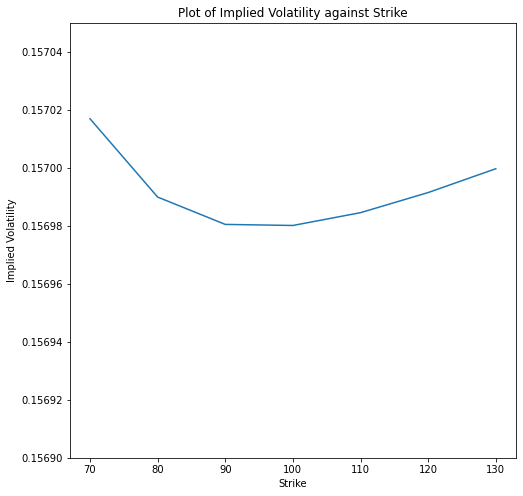

In [60]:
plt.figure(figsize=(8,8))
plt.plot(strike_range,IVByStrike)
plt.ylim(0.1569,0.15705)
plt.title("Plot of Implied Volatility against Strike")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")

## Down and In Barrier Put

Start with down and out barrier put and use in out parity

First calculate put option under constant and local volatility models

In [79]:
#adjust matrices A,B,C for local sigma
s0=100
K=100
T=1
r=0.01

a=sigma_matrix**2*(s**2)/2
b=r*s
c=r

A=dt/(ds**2)*a-dt/(2*ds)*b
B=-2*dt/(ds**2)*a-dt*c
C=dt/ds**2*a+dt/(2*ds)*b

v_cn=np.maximum(K-s,0)
theta=1/2

I= np.identity(M+1)

for n in range(1,N+1):
    L_diag_lhs=tridiagonal_L(n)
    L_diag_rhs=tridiagonal_L(n-1)
    
    d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
    #apply boundary condition
    d[M]=0
    d[0]=K
    a_diag=np.diag(L_diag_lhs,-1)*theta
    b_diag=np.diag(L_diag_lhs)*theta
    c_diag=np.diag(L_diag_lhs,1)*theta
    v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)
    
put_local=v_cn

In [105]:
put_local[179]

5.969956283871837

In [104]:
sigma_matrix

array([[0.44174204, 0.43837482, 0.4350411 , ..., 0.10437858, 0.10436818,
        0.10435788],
       [0.44173848, 0.43837129, 0.43503759, ..., 0.10437774, 0.10436734,
        0.10435704],
       [0.44173492, 0.43836775, 0.43503409, ..., 0.1043769 , 0.1043665 ,
        0.1043562 ],
       ...,
       [0.42749943, 0.42424077, 0.42101454, ..., 0.10101321, 0.10100315,
        0.10099318],
       [0.42749586, 0.42423723, 0.42101103, ..., 0.10101237, 0.10100231,
        0.10099234],
       [0.4274923 , 0.4242337 , 0.42100752, ..., 0.10101153, 0.10100147,
        0.1009915 ]])

In [84]:
#adjust matrices A,B,C for constant sigma
s0=100
K=100
T=1
r=0.01

a=sigma_matrix_const**2*(s**2)/2
b=r*s
c=r

A=dt/(ds**2)*a-dt/(2*ds)*b
B=-2*dt/(ds**2)*a-dt*c
C=dt/ds**2*a+dt/(2*ds)*b

v_cn=np.maximum(K-s,0)
theta=1/2

I= np.identity(M+1)

for n in range(1,N+1):
    L_diag_lhs=tridiagonal_L(n)
    L_diag_rhs=tridiagonal_L(n-1)
    
    d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
    #apply boundary condition
    d[0]=K
    d[M]=0
    a_diag=np.diag(L_diag_lhs,-1)*theta
    b_diag=np.diag(L_diag_lhs)*theta
    c_diag=np.diag(L_diag_lhs,1)*theta
    v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)
    
put_constant=v_cn

In [103]:
put_constant[180]

5.740143859642648

In [106]:
def Crank_Nicholson_Barrier(barrier):
    barrier_indicator=(s>barrier)
    v_cn=np.maximum(K-s,0)*barrier_indicator
    theta=1/2
    
    barrier_index=np.where(s==barrier)[0][0] #find the s-index that corresponds to the barrier value

    I= np.identity(M+1)

    for n in range(1,N+1):
        L_diag_lhs=tridiagonal_L(n)
        L_diag_rhs=tridiagonal_L(n-1)

        d=np.matmul((I+(1-theta)*L_diag_rhs),v_cn) #calculate rhs matrix
        #apply boundary condition
        d[M]=0
        d[0:(barrier_index+1)]=0 #any time the asset prices is at or below the barrier option value is 0 and stays there
        a_diag=np.diag(L_diag_lhs,-1)*theta
        b_diag=np.diag(L_diag_lhs)*theta
        c_diag=np.diag(L_diag_lhs,1)*theta
        v_cn=TDMAsolver(-a_diag,1-b_diag,-c_diag,d)
    
    return v_cn

Down and Out

In [107]:
#first compute the down and out and use in and out parity
#Finite difference is the same as a normal put but we have the extra boundary condition implied by the barrier

#adjust matrices A,B,C for local sigma
s0=100
K=100
T=1
r=0.01

s0_index=np.where(s==s0)[0][0]

a=sigma_matrix**2*(s**2)/2
b=r*s
c=r

A=dt/(ds**2)*a-dt/(2*ds)*b
B=-2*dt/(ds**2)*a-dt*c
C=dt/ds**2*a+dt/(2*ds)*b

barrier_range=np.linspace(60,90,4)

local_vol_barrier_do=np.zeros(len(barrier_range))

# Crank-Nicholson
for i,barrier in enumerate(barrier_range):
    local_vol_barrier_do[i]=Crank_Nicholson_Barrier(barrier)[s0_index]
    

In [109]:
local_vol_barrier_do

array([5.50592107, 4.50960422, 2.2307752 , 0.27483784])

In [110]:
#adjust matrices A,B,C for constant sigma
s0=100
K=100
T=1
r=0.01

s0_index=np.where(s==s0)[0][0]

a=sigma_matrix_const**2*(s**2)/2
b=r*s
c=r

A=dt/(ds**2)*a-dt/(2*ds)*b
B=-2*dt/(ds**2)*a-dt*c
C=dt/ds**2*a+dt/(2*ds)*b

barrier_range=np.linspace(60,90,4)

const_vol_barrier_do=np.zeros(len(barrier_range))

# Crank-Nicholson
for i,barrier in enumerate(barrier_range):
    const_vol_barrier_do[i]=Crank_Nicholson_Barrier(barrier)[s0_index]
    

In [111]:
const_vol_barrier_do

array([5.69261818, 5.03491271, 2.64061556, 0.3114502 ])

In [112]:
#calculate down and in price for both models

local_vol_barrier_di=put_local[s0_index]-local_vol_barrier_do
const_vol_barrier_di=put_constant[s0_index]-const_vol_barrier_do

In [113]:
local_vol_barrier_di

array([0.22824806, 1.22456492, 3.50339394, 5.45933129])

In [114]:
const_vol_barrier_di

array([0.04752568, 0.70523115, 3.0995283 , 5.42869366])

In [115]:
vol_model_barrier=pd.DataFrame([local_vol_barrier_di,const_vol_barrier_di]).transpose()
vol_model_barrier.columns=['Local','Constant']
vol_model_barrier.index=barrier_range
vol_model_barrier['%-Difference']=100*(vol_model_barrier['Local']-vol_model_barrier['Constant'])/(vol_model_barrier['Constant'])

In [116]:
vol_model_barrier

,Local,Constant,%-Difference
60.0,0.228248,0.047526,380.262595
70.0,1.224565,0.705231,73.640220
80.0,3.503394,3.099528,13.029907
90.0,5.459331,5.428694,0.564365


In [7]:
def bs_barrier(s0,k,r,sigma,t,b):
    d1=(np.log(s0/k)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
    d2=d1-sigma*np.sqrt(t)
    d3=d1+2/(sigma*np.sqrt(t))*np.log(b/s0)
    d4=d2+2/(sigma*np.sqrt(t))*np.log(b/s0)
    delta=2*r/sigma**2
    
    bs_price=s0*(stats.norm.cdf(d1)-(b/s0)**(delta+1)*stats.norm.cdf(d3))-k*np.exp(-r*t)*(stats.norm.cdf(d2)-(b/s0)**(delta-1)*stats.norm.cdf(d4))
    return bs_price

In [8]:
bs_barrier(100,100,0.01,0.157,1,60)

6.735945036246825

In [41]:
def bs_dig_put(s0,k,r,sigma,t):
    d2=(np.log(s0/k)+(r-sigma**2/2)*t)/(sigma*np.sqrt(t))
    return np.exp(-r*t)*stats.norm.cdf(-d2)

In [35]:
def bs_put(s0,k,r,sigma,t):
    d1=(np.log(s0/k)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
    d2=d1-sigma*np.sqrt(t)
    
    return k*np.exp(-r*t)*stats.norm.cdf(-d2)-s0*stats.norm.cdf(-d1)

In [42]:
def barrier_put(s0,k,r,sigma,t,b):
    alpha=1/2*(1-2*r/sigma**2)
    price=bs_put(s0,k,r,sigma,t)-bs_put(s0,b,r,sigma,t)-(k-b)*bs_dig_put(s0,b,r,sigma,t)-\
    (s0/b)**(2*alpha)*(bs_put(b**2/s0,k,r,sigma,t)-bs_put(b**2/s0,b,r,sigma,t)+(k-b)*bs_dig_put(b**2/s0,b,r,sigma,t))
    
    return price
    

In [49]:
bs_dig_put(100,100,0.01,0.157,1)

0.500872563933357

In [48]:
barrier_put(100,100,0.01,0.157,1,)

0.9499444914872852